# Modeling

- 1. [Introduction](#1.-Introduction)
- 2. [Imports](#2.-Imports)
- 3. [Loading the data](#3.-Loading-the-data)
- 4. [Sampling](#4.-Sampling)
    - 4.1 [Types of Sampling](#4.1-Types-of-Sampling)
    - 4.2 [Validation and Testing Set Distributions](#4.2-Validation-and-Testing-Set-Distributions)
- 5. [Model Selection](#5.-Model-Selection)
    - 5.1 [Baseline Models](#5.1-Baseline-Models)
    - 5.2 [Linear Models](#5.2-Linear-Models)
    - 5.3 [Tree Models](#5.3-Tree-Models)
    - 5.4 [Ensemble Methods](#5.4-Ensemble-Methods)
    
- 6. [Conclusion](#6.-Conclusion)


# 1. Introduction 

In this notebook, we perform select and evaluate models in an attempt to predict early readmission in diabetic patients. Previously, we've split our pre-processed data into training and test sets, which we will be using to train and evaluate our models respectively.

# 2. Imports

In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from functools import partial

from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier

from src.data import load_dataset as ld
from src.models.lace_index import LACEIndexClassifier
from src.models.evaluate import classification_report_from_models, train_models_over_samples, classification_report_over_samples, plot_roc_over_folds, \
plot_roc_over_models, kfold_samples, plot_feature_importance

pd.options.display.max_columns = 100

RANDOM_SEED = 0

# 3. Loading the data

In [2]:
training_data = ld.load_preprocessed_pickle('train.pkl')
testing_data = ld.load_preprocessed_pickle('test.pkl')
training_data_lace = ld.load_preprocessed_pickle('train_lace.pkl')

In [3]:
X_train, y_train = ld.split_dataset(training_data)
X_test, y_test = ld.split_dataset(testing_data)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55956, 80), (55956,), (14007, 80), (14007,))

In [5]:
X_train_lace, y_train_lace = ld.split_dataset(training_data_lace)
X_train_lace.shape, y_train_lace.shape

((55956, 20), (55956,))

# 4. Sampling

## 4.1 Types of Sampling

The original dataset had a rough 9:1 ratio of negative to positive observations and with such few observations in our minority class, our model may not learn a useful decision boundary. To combat this class imbalance in our training data, we experiment with different oversampling and undersampling techniques:
- **Random Oversampling**: Duplicate minority observations in our dataset by randomly sampling the minority class with replacement
- **SMOTE (Synthetic Minority Oversampling Technique)**: Synthesize novel minority observations that are similar to other minority observations in the feature space
- **Random Undersampling**: Randomly omit observations from the majority class

Other considerations:
- **SMOTE and Tomek Links**: SMOTE over-samples the minority class to create a more even representation between the two classes and Tomek Links, an undersampling technique, removes neighbors that are nearby in the feature space but belong to different classes, in order to increase the separation between the major and minor classes. imblearn's SMOTETomek implementation is very computationally intensive so it was not practical to experiment with this procedure for all models. Additionally, although increasing the separation between major and minor classes may improve generalization in theory, we observed in a reduced dimensional feature space that many positive observations were, in fact, near negative observations. Removing these pairs of neighbors may prevent our model from learning these nuances that differentiate these geometrically similar observations.

Here we initialize our sampling methods and the stratified k-fold helper we will be using during model evaluation:

In [6]:
smote = SMOTE(random_state=RANDOM_SEED, n_jobs=-1)
random_oversampler = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)
random_undersampler = RandomUnderSampler(random_state=RANDOM_SEED)

sampling_methods = [
    ('Initial data', None),
    ('SMOTE', smote),
    ('Random Oversampling', random_oversampler),
    ('Random Undersampling', random_undersampler)
]

In [7]:
skf = StratifiedKFold(n_splits=3, random_state=RANDOM_SEED, shuffle=True)

In [8]:
samples = kfold_samples(skf, X_train, y_train, sampling_methods)

In [9]:
def roc_plots(estimator, sampling_methods=sampling_methods):
    _, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes_iter = iter(axes.flatten())
    for name, sampler in sampling_methods:
        ax = next(axes_iter)
        plot_roc_over_folds(X_train, y_train, skf, estimator, sampler, ax=ax)
        ax.set_title(ax.get_title() + f' (sampling={name})')
    plt.tight_layout()
    
def plot_model_roc(model_sample_pairs):
    _, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes_iter = iter(axes.flatten())
    step = 3
    for i in range(0, len(model_sample_pairs), step):
        ax = next(axes_iter)
        plot_roc_over_models(model_sample_pairs[i:i+step], ax=ax)
    
    plt.tight_layout()
    
def plot_model_feature_importance(model_sample_pairs, figsize=(25, 20)):
    _, axes = plt.subplots(4, 3, figsize=figsize)
    axes_iter = iter(axes.flatten())
    for i, (estimator, X_train, _, _, _) in enumerate(model_sample_pairs):
        ax = next(axes_iter)
        plot_feature_importance(estimator.feature_importances_, X_train.columns, max_num=10, title=f'{estimator.__sample__} (fold={i%3})', ax=ax)
    
    plt.suptitle(f'Feature Importances for {estimator.__class__.__name__}', y=1.025, fontsize='x-large', fontweight='bold')
    plt.tight_layout() 

## 4.2 Validation and Testing Set Distributions
An assumption that we're making about our validation set is that its observations come from the same distribution as the test set. If they come from different distributions, our validation set is useless and we don't expect our models to learn patterns that will generalize well to unseen data.

In this offline learning project, we have created our own test set. Having access to both the validation and test set, we can manually verify that they are drawn from approximately distributions:

- For each validation set that we constructed through stratified sampling, we construct a new dataset composed of the validation set, $V$, and a random stratified sample of the test set of size equal to that of the validation set, $T$.
- We set the target variables of the observations in $V$ to 1 and the target variables of the observations in $T$ to 0.
- We then train a classifier to differentiate between observations in $V$ and $T$ and generate a cross-validated accuracy score. If the score is approximately 50%, then our classifier was not able to sufficiently distinguish observations from $T$ and $V$, and, as a result, we can be more confident that they are drawn from approximately identical distributions.

In [10]:
for i, (_, validation_indices) in enumerate(StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True).split(X_train, y_train)):
    xv = X_train.iloc[validation_indices]
    yv = pd.Series(np.ones((len(xv),)))
    
    xt, _, yt, _ = train_test_split(X_test, y_test, stratify=y_test, test_size=1-len(xv)/len(X_test), random_state=RANDOM_SEED)
    yt = pd.Series(np.zeros((len(xt,))))
    
    X = pd.concat([xv, xt], axis=0).reset_index(drop=True)
    y = pd.concat([yv, yt], axis=0).reset_index(drop=True)
    clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
    
    accuracies = []
    for (_, (ti, vi)) in enumerate(StratifiedKFold(n_splits=3, random_state=RANDOM_SEED, shuffle=True).split(X, y)):
        clf.fit(X.iloc[ti], y.iloc[ti].to_numpy().flatten())
        y_pred = clf.predict(X.iloc[vi])
        accuracies.append(accuracy_score(y.iloc[vi], y_pred))

    print(f'Fold {i}: Mean CV accuracy={sum(accuracies) / len(accuracies)}')

Fold 0: Mean CV accuracy=0.4945498180221179
Fold 1: Mean CV accuracy=0.5077074484070219
Fold 2: Mean CV accuracy=0.5052499688879641
Fold 3: Mean CV accuracy=0.49381185500916946
Fold 4: Mean CV accuracy=0.5019885351998399


The mean average cross-validated accuracy oscillates around 0.5 across folds. Therefore, we can trust that the means by which we generate our validation set is representative of the testing set, which we'll eventually use to assess our model's final performance.

# 5. Model Selection

Our learning task is to identify early readmission patient encounters. We experiment with a collection of candidate models and sampling methods to:
1. Determine the sampling method that performs best during validation
2. Identify a subset of candidate models that demonstrates promising results in order to reduce the scope of our hyperparameter tuning
3. Begin to understand the subset of features that is most critical for learning

Our evaluation of these candidate models are based on its utility in practice. A false negative (a patient who fails to be classified as someone who will likely re-admit within 30 days) has much more dire health and financial implications than those of a false positive. With that in mind, we primarily focus on metrics like recall, which tell us how accurately our learner classifies the positive class.

We will evaluate each sampling method-model pair using $K$-fold cross-validation, mean-averaging the following metrics over $K$ folds:
 - **Precision**: The number of patients that we correctly predicted would readmit early per the number of all patients that we predicted would readmit early
 - **Recall**: The number of patients that we correctly predicted would readmit early per the number of all patients that readmitted early
 
 - **f2 Score**: The harmonic mean of both precision and recall. $\beta = 2$, meaning we place more emphasis on minimizing the presence of false negatives
 - **ROC AUC Score**: The probability that the model ranks a random positive observation more highly than a random negative observation.


| Average Precision Score | Average Recall Score | Average f2-score ($\beta = 2$)| Average ROC AUC |
| ----------------- | --------------------- | ----------------------------- | --------------- |
$\frac{1}{K}\sum_{i=0}^{K}\frac{TP}{TP + FP}$ | $\frac{1}{K}\sum_{i=0}^{K} \frac{TP}{TP + FN}$ | $\frac{1}{K}\sum_{i=0}^{K} \frac{(1 + \beta^2) PR}{\beta^2 P + R}$ | $\frac{1}{K}\sum_{i=0}^{K} \int_{0}^{1} ROC$



## 5.1 Baseline Models

### 5.1.1 Dummy Classifier

We first train a dummy classifier, based on a basic heuristic of using the most frequently occurring label as a prediction.

In [3]:
ld.load_data('../metrics/baseline/baseline_results_DummyClassifier.pkl')

Average Precision  Average Recall  \
model                                                              
DummyClassifier initial_data                 0.0             0.0   
                smote                        0.0             0.0   
                over_sampled                 0.0             0.0   
                under_sampled                0.0             0.0   

                               Average f2-score  Average ROC AUC  \
model                                                              
DummyClassifier initial_data                0.0              0.5   
                smote                       0.0              0.5   
                over_sampled                0.0              0.5   
                under_sampled               0.0              0.5   

                               Average # of Positive Obs.  \
model                                                       
DummyClassifier initial_data                  3347.333333   
                smote                        33956.666667   
                over_sampled                 33956.666667   
                under_sampled                 3347.333333   

                               Average # of Negative Obs.  \
model                                                       
DummyClassifier initial_data                 33956.666667   
                smote                        33956.666667   
                over_sampled                 33956.666667   
                under_sampled                 3347.333333   

                               Average Proportion of Positive Obs.  
model                                                               
DummyClassifier initial_data                              0.089731  
                smote                                     0.500000  
                over_sampled                              0.500000  
                under_sampled                             0.500000

![DummyClassifier ROC AUC plot](../metrics/baseline/roc_auc_plot_DummyClassifier.png)

### 5.1.2 LACE Index



In [15]:
lace = LACEIndexClassifier()

lace_sampling_methods = [
    ('Initial data', None),
    ('SMOTE', SMOTENC(random_state=RANDOM_SEED, categorical_features=np.arange(2, len(X_train_lace.columns)))),
    ('Random Oversampling', random_oversampler),
    ('Random Undersampling', random_undersampler)
]

lace_samples = kfold_samples(skf, X_train_lace, y_train_lace, lace_sampling_methods)
lace_models = train_models_over_samples(lace, lace_samples)

In [16]:
classification_report_from_models(lace_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.102237,0.495921,0.280149,0.546603,3347.333333,33956.666667,0.089731
Random Oversampling,0.102237,0.495921,0.280149,0.546603,33956.666667,33956.666667,0.500000
Random Undersampling,0.102237,0.495921,0.280149,0.546603,3347.333333,3347.333333,0.500000
SMOTE,0.102237,0.495921,0.280149,0.546603,33956.666667,33956.666667,0.500000


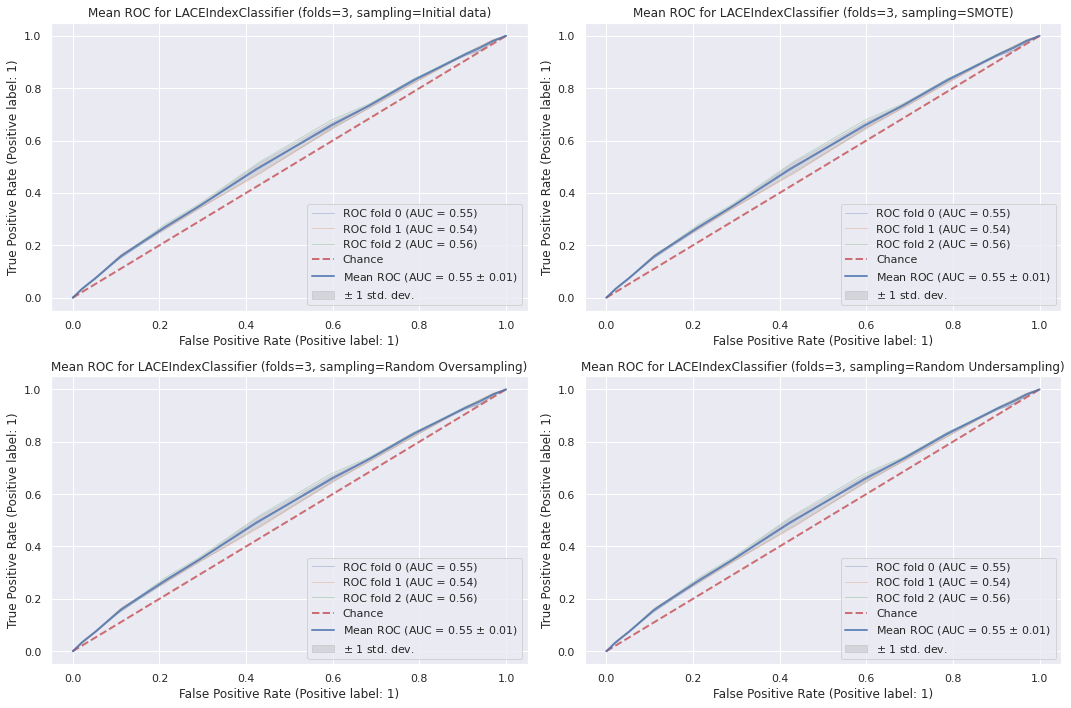

In [17]:
plot_model_roc(lace_models)

In [18]:
del lace_models; del lace_samples; del lace;

## 5.2 Linear Models
### 5.2.1 Logistic Regression

In [4]:
ld.load_data('../metrics/baseline/baseline_results_LogisticRegression.pkl')

Average Precision  Average Recall  \
model                                                                 
LogisticRegression initial_data            0.000000        0.000000   
                   smote                   0.099643        0.110933   
                   over_sampled            0.132624        0.555070   
                   under_sampled           0.131576        0.568415   

                                  Average f2-score  Average ROC AUC  \
model                                                                 
LogisticRegression initial_data           0.000000         0.637885   
                   smote                  0.108451         0.522122   
                   over_sampled           0.339045         0.638730   
                   under_sampled          0.341563         0.635730   

                                  Average # of Positive Obs.  \
model                                                          
LogisticRegression initial_data                  3347.333333   
                   smote                        33956.666667   
                   over_sampled                 33956.666667   
                   under_sampled                 3347.333333   

                                  Average # of Negative Obs.  \
model                                                          
LogisticRegression initial_data                 33956.666667   
                   smote                        33956.666667   
                   over_sampled                 33956.666667   
                   under_sampled                 3347.333333   

                                  Average Proportion of Positive Obs.  
model                                                                  
LogisticRegression initial_data                              0.089731  
                   smote                                     0.500000  
                   over_sampled                              0.500000  
                   under_sampled                             0.500000

![LogisticRegression ROC AUC plot](../metrics/baseline/roc_auc_plot_LogisticRegression.png)

## 5.3 Tree Models

### 5.3.1 Decision Tree

In [6]:
ld.load_data('../metrics/baseline/baseline_results_DecisionTreeClassifier.pkl')

Average Precision  Average Recall  \
model                                                                     
DecisionTreeClassifier initial_data            0.117144        0.142203   
                       smote                   0.102965        0.147780   
                       over_sampled            0.111211        0.124279   
                       under_sampled           0.102181        0.536743   

                                      Average f2-score  Average ROC AUC  \
model                                                                     
DecisionTreeClassifier initial_data           0.136368         0.518279   
                       smote                  0.135938         0.510378   
                       over_sampled           0.121419         0.513185   
                       under_sampled          0.290039         0.535938   

                                      Average # of Positive Obs.  \
model                                                              
DecisionTreeClassifier initial_data                  3347.333333   
                       smote                        33956.666667   
                       over_sampled                 33956.666667   
                       under_sampled                 3347.333333   

                                      Average # of Negative Obs.  \
model                                                              
DecisionTreeClassifier initial_data                 33956.666667   
                       smote                        33956.666667   
                       over_sampled                 33956.666667   
                       under_sampled                 3347.333333   

                                      Average Proportion of Positive Obs.  
model                                                                      
DecisionTreeClassifier initial_data                              0.089731  
                       smote                                     0.500000  
                       over_sampled                              0.500000  
                       under_sampled                             0.500000

![DecisionTreeClassifier ROC AUC plot](../metrics/baseline/roc_auc_plot_DecisionTreeClassifier.png)

## 5.4 Ensemble Methods

### 5.4.1 Random Forest Classifier

In [8]:
ld.load_data('../metrics/baseline/baseline_results_RandomForestClassifier.pkl')

Average Precision  Average Recall  \
model                                                                     
RandomForestClassifier initial_data            0.333333        0.000199   
                       smote                   0.127862        0.009759   
                       over_sampled            0.374008        0.004382   
                       under_sampled           0.126645        0.576579   

                                      Average f2-score  Average ROC AUC  \
model                                                                     
RandomForestClassifier initial_data           0.000249         0.612964   
                       smote                  0.011967         0.580174   
                       over_sampled           0.005461         0.616292   
                       under_sampled          0.337059         0.629014   

                                      Average # of Positive Obs.  \
model                                                              
RandomForestClassifier initial_data                  3347.333333   
                       smote                        33956.666667   
                       over_sampled                 33956.666667   
                       under_sampled                 3347.333333   

                                      Average # of Negative Obs.  \
model                                                              
RandomForestClassifier initial_data                 33956.666667   
                       smote                        33956.666667   
                       over_sampled                 33956.666667   
                       under_sampled                 3347.333333   

                                      Average Proportion of Positive Obs.  
model                                                                      
RandomForestClassifier initial_data                              0.089731  
                       smote                                     0.500000  
                       over_sampled                              0.500000  
                       under_sampled                             0.500000

![RandomForestClassifier ROC AUC plot](../metrics/baseline/roc_auc_plot_RandomForestClassifier.png)

### 5.4.2 Gradient Boosting Classifier

In [9]:
ld.load_data('../metrics/baseline/baseline_results_GradientBoostingClassifier.pkl')

Average Precision  Average Recall  \
model                                                                         
GradientBoostingClassifier initial_data            0.357407        0.002589   
                           smote                   0.140719        0.039434   
                           over_sampled            0.139169        0.541726   
                           under_sampled           0.133932        0.556262   

                                          Average f2-score  Average ROC AUC  \
model                                                                         
GradientBoostingClassifier initial_data           0.003230         0.646958   
                           smote                  0.046050         0.562541   
                           over_sampled           0.343106         0.646309   
                           under_sampled          0.341046         0.642883   

                                          Average # of Positive Obs.  \
model                                                                  
GradientBoostingClassifier initial_data                  3347.333333   
                           smote                        33956.666667   
                           over_sampled                 33956.666667   
                           under_sampled                 3347.333333   

                                          Average # of Negative Obs.  \
model                                                                  
GradientBoostingClassifier initial_data                 33956.666667   
                           smote                        33956.666667   
                           over_sampled                 33956.666667   
                           under_sampled                 3347.333333   

                                          Average Proportion of Positive Obs.  
model                                                                          
GradientBoostingClassifier initial_data                              0.089731  
                           smote                                     0.500000  
                           over_sampled                              0.500000  
                           under_sampled                             0.500000

![GradientBoostingClassifier ROC AUC plot](../metrics/baseline/roc_auc_plot_GradientBoostingClassifier.png)

### 5.4.3 Light GBM Classifier

In [10]:
ld.load_data('../metrics/baseline/baseline_results_LGBMClassifier.pkl')

Average Precision  Average Recall  \
model                                                             
LGBMClassifier initial_data            0.194444        0.001593   
               smote                   0.151160        0.003785   
               over_sampled            0.143213        0.457478   
               under_sampled           0.130100        0.566417   

                              Average f2-score  Average ROC AUC  \
model                                                             
LGBMClassifier initial_data           0.001988         0.637566   
               smote                  0.004700         0.603688   
               over_sampled           0.317815         0.630941   
               under_sampled          0.338993         0.633050   

                              Average # of Positive Obs.  \
model                                                      
LGBMClassifier initial_data                  3347.333333   
               smote                        33956.666667   
               over_sampled                 33956.666667   
               under_sampled                 3347.333333   

                              Average # of Negative Obs.  \
model                                                      
LGBMClassifier initial_data                 33956.666667   
               smote                        33956.666667   
               over_sampled                 33956.666667   
               under_sampled                 3347.333333   

                              Average Proportion of Positive Obs.  
model                                                              
LGBMClassifier initial_data                              0.089731  
               smote                                     0.500000  
               over_sampled                              0.500000  
               under_sampled                             0.500000

![LGBMClassifier ROC AUC plot](../metrics/baseline/roc_auc_plot_LGBMClassifier.png)

### 5.4.4 XGBoost

In [11]:
ld.load_data('../metrics/baseline/baseline_results_XGBClassifier.pkl')

Average Precision  Average Recall  \
model                                                            
XGBClassifier initial_data            0.280174        0.014539   
              smote                   0.242165        0.018124   
              over_sampled            0.140854        0.335790   
              under_sampled           0.119584        0.563233   

                             Average f2-score  Average ROC AUC  \
model                                                            
XGBClassifier initial_data           0.017941         0.613553   
              smote                  0.022231         0.593561   
              over_sampled           0.262978         0.598392   
              under_sampled          0.323324         0.611478   

                             Average # of Positive Obs.  \
model                                                     
XGBClassifier initial_data                  3347.333333   
              smote                        33956.666667   
              over_sampled                 33956.666667   
              under_sampled                 3347.333333   

                             Average # of Negative Obs.  \
model                                                     
XGBClassifier initial_data                 33956.666667   
              smote                        33956.666667   
              over_sampled                 33956.666667   
              under_sampled                 3347.333333   

                             Average Proportion of Positive Obs.  
model                                                             
XGBClassifier initial_data                              0.089731  
              smote                                     0.500000  
              over_sampled                              0.500000  
              under_sampled                             0.500000

![XGBClassifier ROC AUC plot](../metrics/baseline/roc_auc_plot_XGBClassifier.png)

## 5.5 Results

In [14]:
ld.load_data('../metrics/baseline/mean_scores_by_sampler.pkl')

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
initial_data,0.173666,0.116159,0.061924,0.597096,3347.333333,33956.666667,0.089731
over_sampled,0.142074,0.369846,0.216110,0.594285,33956.666667,33956.666667,0.500000
smote,0.119136,0.101373,0.072968,0.545747,33956.666667,33956.666667,0.500000
under_sampled,0.107966,0.485053,0.278139,0.599580,3347.333333,3347.333333,0.500000


Above, we show the average scores for various metrics of each type of sampling method. Random undersampling method demonstrates the best performance in our key metrics (recall, ROC AUC, f2-score). Random oversampling also demonstrates a solid performance in the recall and ROC AUC metrics while also yielding a higher average precision score than random undersampling. Using our initial data, without any re-sampling method, yields the highest average precision and ROC AUC score, but de-prioritizes recall, resulting in the lowest average f2 score of all four categories. SMOTE consistently performs badly in all selected metrics.

In [28]:
results = ld.load_data('../metrics/baseline/baseline_model_total_results.pkl')
results

Average Precision  Average Recall  \
model                                                                         
DummyClassifier            initial_data            0.000000        0.000000   
                           smote                   0.000000        0.000000   
                           over_sampled            0.000000        0.000000   
                           under_sampled           0.000000        0.000000   
LogisticRegression         initial_data            0.000000        0.000000   
                           smote                   0.099643        0.110933   
                           over_sampled            0.132624        0.555070   
                           under_sampled           0.131576        0.568415   
GaussianNB                 initial_data            0.106827        0.768149   
                           smote                   0.088572        0.481171   
                           over_sampled            0.095516        0.940045   
                           under_sampled           0.119714        0.512774   
DecisionTreeClassifier     initial_data            0.117144        0.142203   
                           smote                   0.102965        0.147780   
                           over_sampled            0.111211        0.124279   
                           under_sampled           0.102181        0.536743   
RandomForestClassifier     initial_data            0.333333        0.000199   
                           smote                   0.127862        0.009759   
                           over_sampled            0.374008        0.004382   
                           under_sampled           0.126645        0.576579   
GradientBoostingClassifier initial_data            0.357407        0.002589   
                           smote                   0.140719        0.039434   
                           over_sampled            0.139169        0.541726   
                           under_sampled           0.133932        0.556262   
LGBMClassifier             initial_data            0.194444        0.001593   
                           smote                   0.151160        0.003785   
                           over_sampled            0.143213        0.457478   
                           under_sampled           0.130100        0.566417   
XGBClassifier              initial_data            0.280174        0.014539   
                           smote                   0.242165        0.018124   
                           over_sampled            0.140854        0.335790   
                           under_sampled           0.119584        0.563233   

                                          Average f2-score  Average ROC AUC  \
model                                                                         
DummyClassifier            initial_data           0.000000         0.500000   
                           smote                  0.000000         0.500000   
                           over_sampled           0.000000         0.500000   
                           under_sampled          0.000000         0.500000   
LogisticRegression         initial_data           0.000000         0.637885   
                           smote                  0.108451         0.522122   
                           over_sampled           0.339045         0.638730   
                           under_sampled          0.341563         0.635730   
GaussianNB                 initial_data           0.335614         0.609564   
                           smote                  0.254410         0.493511   
                           over_sampled           0.339057         0.610432   
                           under_sampled          0.253089         0.608544   
DecisionTreeClassifier     initial_data           0.136368         0.518279   
                           smote                  0.135938         0.510378   
                           over_sampled           0.121419         0.513185   
            

In [29]:
results[results.index.get_level_values(1) == 'under_sampled']

,,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
model,,,,,,,,
DummyClassifier,under_sampled,0.000000,0.000000,0.000000,0.500000,3347.333333,3347.333333,0.5
LogisticRegression,under_sampled,0.131576,0.568415,0.341563,0.635730,3347.333333,3347.333333,0.5
GaussianNB,under_sampled,0.119714,0.512774,0.253089,0.608544,3347.333333,3347.333333,0.5
DecisionTreeClassifier,under_sampled,0.102181,0.536743,0.290039,0.535938,3347.333333,3347.333333,0.5
RandomForestClassifier,under_sampled,0.126645,0.576579,0.337059,0.629014,3347.333333,3347.333333,0.5
GradientBoostingClassifier,under_sampled,0.133932,0.556262,0.341046,0.642883,3347.333333,3347.333333,0.5
LGBMClassifier,under_sampled,0.130100,0.566417,0.338993,0.633050,3347.333333,3347.333333,0.5
XGBClassifier,under_sampled,0.119584,0.563233,0.323324,0.611478,3347.333333,3347.333333,0.5


Logistic regression and the tree-based ensemble methods performed the best on average. The three gradient-boosted tree implementations, GradientBoostingClassifier, LightGBM, XGBoost, performed well and yielded comparable scores. The GradientBoostingClassifier implementation appeared to prioritize precision more than the others. LightGBM was the most time and resource efficient and yielded the highest recall score. Random forest yielded the highest recall score among all classifiers.

Based on these initial results, we will be tuning the hyperparameters for logistic regression, random forest, and LGBM classifiers in the next section.

# 6. Conclusion

In this notebook, we defined a suite of metrics that would be most useful in evaluating models with respect to our data. Our data is imbalanced, where early readmission patients only account for about 9% of our dataset. We decided to evaluate models with precision, recall, f2-score, and ROC AUC. We prioritize the recall score and weighted metrics like the f2-score, as we would like to minimize false negatives.

Class imbalance risks biasing our models by exposing them to a disproportionate number of observations per class. We explored sampling methods to counteract this. We experimented with SMOTE (Synthetic Minority Oversampling Technique), random oversampling the minority class, and random undersampling the majority class. We then performed 3-fold cross-validation on each of these generated datasets to determine which method yielded the best overall performance and to also get a general idea of which types of models are most effective in learning from our data. Random undersampling yielded higher recall values on average, without sacrificing precision or ROC AUC. SMOTE performed the worst on average among all non-dummy models.

We evaluated both a dummy classifier that predicted the most frequent class in our training data and a LACE index classifier, which predicts early readmission based on well-known features like the number of emergency visits the patient had in the past year or the kinds of comorbidities they have. The LACE index performed only marginally better than the dummy classifier, generating poor precision and recall scores and an ROC AUC score that was barely better than random. This indicates that the current heuristic for identifying early readmission is lacking and that there is room for improvement. 

Logistic regression and tree-based ensemble methods tend to perform better on average. We will consider logistic regression, random forest, LGBM classifiers to optimize given their effectiveness and their reasonable training speed.
 
We plotted feature importances for each model, sampling method, fold combination. The number of in-patient visits, number of medications, number of lab procedures, days in the hospital, and transferring to a skilled nursing facility or an undefined health institution appear to be important features.

With this in mind, we will try to improve our model through hyperparameter optimization in our next notebook.